# Modeling - Extra Trees

### Summary:
This notebook aims to establish the viability of the Extra Trees algorithm for the purpose of modeling critical wine ratings using scraped weather data. Supporting these goals, performance metrics, residual plots, and feature importance’s are generated to support comparison across model families.

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import dill
from scipy.stats import uniform, randint

# preprocessing packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.impute import SimpleImputer

# pipeline tools
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, RepeatedKFold

# feature selection tools
from sklearn.feature_selection import VarianceThreshold

# models
from sklearn.ensemble import ExtraTreesRegressor

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
# establish directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
processed_data_folder = parent_directory + '/data/wunderground-com/processed/'
models_folder = parent_directory + '/models/'
images_folder = parent_directory + '/images/'

### Load Data

In [3]:
df = pd.read_csv(processed_data_folder + '1678665697.3855994.txt', 
                 sep = '|')

In [4]:
df.head()

,Product_Name,Product_Varietal,Product_Origin,Product_Price,Product_Attributes,User_Avg_Rating,User_Rating_Count,Product_Vintage,Critical_Avg_Rating,Critical_Rating_Count,...,Jan_Min_Low_Wind_Speed,Jan_Max_High_Pressure,Jan_Avg_High_Pressure,Jan_Min_High_Pressure,Jan_Avg_Pressure,Jan_Max_Low_Pressure,Jan_Avg_Low_Pressure,Jan_Min_Low_Pressure,Jan_Average_Precipitation,Jan_Total_Precipitation
0,Domaine Taupenot-Merme Nuits-Saint-Georges Les...,Pinot Noir,"Nuits-St-Georges, Cote de Nuits, Cote d'Or, Bu...",199.99,Red Wine,0.0,0,2017,93.000000,3,...,0.0,29.8,29.493548,29.1,29.416129,29.8,29.354839,28.7,0.000000,0.00
1,Domaine de la Romanee-Conti Echezeaux Grand Cru,Pinot Noir,"Flagey-Echezeaux, Cote de Nuits, Cote d'Or, Bu...","3,299.99",Red Wine,0.0,0,2018,95.000000,4,...,0.0,29.9,29.384211,28.9,29.252632,29.8,29.157895,28.8,0.000000,0.00
2,Lincourt Rancho Santa Rosa Pinot Noir,Pinot Noir,"Sta. Rita Hills, Santa Barbara, Central Coast,...",40.99,Red Wine,4.0,31,2018,90.666667,3,...,0.0,30.3,30.135484,29.9,30.064516,30.2,30.000000,29.5,0.087742,2.72
3,Domaine Claude Dugat Gevrey-Chambertin,Pinot Noir,"Gevrey-Chambertin, Cote de Nuits, Cote d'Or, B...",179.99,Red Wine,0.0,0,2020,92.000000,3,...,0.0,29.9,29.558065,29.0,29.477419,29.9,29.400000,28.8,0.000000,0.00
4,Domaine Prieur-Brunet Santenay Maladiere Premi...,Pinot Noir,"Santenay, Cote de Beaune, Cote d'Or, Burgundy,...",65.99,Red Wine,0.0,0,2020,92.333333,3,...,0.0,29.9,29.558065,29.0,29.477419,29.9,29.400000,28.8,0.000000,0.00


In [5]:
df.columns

Index(['Product_Name', 'Product_Varietal', 'Product_Origin', 'Product_Price',
       'Product_Attributes', 'User_Avg_Rating', 'User_Rating_Count',
       'Product_Vintage', 'Critical_Avg_Rating', 'Critical_Rating_Count',
       ...
       'Jan_Min_Low_Wind_Speed ', 'Jan_Max_High_Pressure',
       'Jan_Avg_High_Pressure', 'Jan_Min_High_Pressure', 'Jan_Avg_Pressure',
       'Jan_Max_Low_Pressure', 'Jan_Avg_Low_Pressure', 'Jan_Min_Low_Pressure',
       'Jan_Average_Precipitation', 'Jan_Total_Precipitation'],
      dtype='object', length=456)

In [6]:
df.shape

(1115, 456)

### Missing Data & Data Type Correction

In [7]:
df.isnull().sum().sum()

0

### Reduce to Input Data and Assign Predictive and Target Feature

In [8]:
# specifying predictive and target features
X = df.drop(columns = ['Product_Name', 'Product_Varietal', 'Product_Origin', 'Product_Price',
       'Product_Attributes', 'User_Avg_Rating', 'User_Rating_Count',
       'Product_Vintage', 'Critical_Avg_Rating', 'Critical_Rating_Count', 'Appellation_Level', 'Weather_Origin'])
y = df[['Critical_Avg_Rating']]

In [9]:
X.columns

Index(['Aug_Max_High_Temperature', 'Aug_Avg_High_Temperature',
       'Aug_Min_High_Temperature', 'Aug_Avg_Temperature',
       'Aug_Max_Low_Temperature', 'Aug_Avg_Low_Temperature',
       'Aug_Min_Low_Temperature', 'Aug_Max_High_ Dew_Point',
       'Aug_Avg_High_ Dew_Point', 'Aug_Min_High_ Dew_Point',
       ...
       'Jan_Min_Low_Wind_Speed ', 'Jan_Max_High_Pressure',
       'Jan_Avg_High_Pressure', 'Jan_Min_High_Pressure', 'Jan_Avg_Pressure',
       'Jan_Max_Low_Pressure', 'Jan_Avg_Low_Pressure', 'Jan_Min_Low_Pressure',
       'Jan_Average_Precipitation', 'Jan_Total_Precipitation'],
      dtype='object', length=444)

In [10]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Critical_Avg_Rating  1115 non-null   float64
dtypes: float64(1)
memory usage: 8.8 KB


In [11]:
# create holdout set to approximate real-world performance
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

## ExtraTrees

In [12]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', None),
                     ('near_zero_variance', VarianceThreshold()),
                     ('etc', ExtraTreesRegressor())])

In [13]:
search_space = [{'near_zero_variance__threshold': uniform(0, 0.05),
                 'scaler' : [StandardScaler(),  
                             MinMaxScaler(), 
                             RobustScaler(),
                             QuantileTransformer()],
                 'etc__n_estimators': randint(10, 1000),
                 'etc__max_leaf_nodes': randint(5, 50), 
                 'etc__max_depth': randint(2, 20)}]

kfold = RepeatedKFold(n_splits=5,
                      n_repeats=10,
                      random_state=123)

etc = RandomizedSearchCV(pipeline,
                         param_distributions = search_space,
                         n_iter = 200,
                         cv = kfold,
                         scoring ='neg_mean_squared_error',
                         n_jobs = -1,
                        random_state = 123)
etc.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % etc.best_score_)
print(etc.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (892). n_quantiles is set to n_samples.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Best parameter (CV score=-3.090):
{'etc__max_depth': 7, 'etc__max_leaf_nodes': 23, 'etc__n_estimators': 707, 'near_zero_variance__threshold': 0.04905588866387389, 'scaler': QuantileTransformer()}


### Holdout Performance

In [14]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, etc.predict(X_test))
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.9387130073327024


In [15]:
# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, etc.predict(X_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.7142674841846306


In [16]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, etc.predict(X_test))
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 1.3535085275154592


In [17]:
# Calculate R-squared (R2)
r2 = r2_score(y_test, etc.predict(X_test))
print("R-squared (R2):", r2)

R-squared (R2): 0.11213643325687872


In [18]:
# Calculate Explained Variance Score (EVS)
evs = explained_variance_score(y_test, etc.predict(X_test))
print("Explained Variance Score (EVS):", evs)

Explained Variance Score (EVS): 0.11568738841875192


### Error Distributions

In [19]:
error_df = pd.DataFrame(y_test, columns = ['Critical_Avg_Rating'])
error_df['y_pred'] = etc.predict(X_test)
error_df['residual'] = error_df['Critical_Avg_Rating'] - error_df['y_pred']

In [20]:
error_df.head()

,Critical_Avg_Rating,y_pred,residual
1014,92.000000,92.075591,-0.075591
742,93.750000,92.987798,0.762202
85,91.666667,93.121989,-1.455322
857,92.000000,93.019658,-1.019658
888,91.666667,93.147734,-1.481068


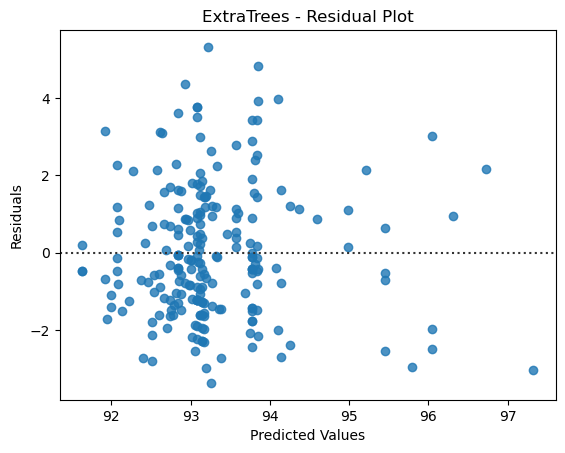

In [21]:
sns.residplot(data = error_df, 
              x = 'y_pred', 
              y = 'residual')
plt.title('ExtraTrees - Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

### Feature Importance

In [22]:
etc_best_pipeline = etc.best_estimator_
importances = np.abs(etc_best_pipeline.named_steps['etc'].feature_importances_)
indices = np.argsort(importances)[::-1]

In [23]:
n = 10
top_n_indices = indices[:n]
top_n_features = X.columns[top_n_indices]

for feature, importance in zip(top_n_features, importances[top_n_indices]):
    print(feature, "=", importance)

Mar_Avg_Low_ Dew_Point = 0.027125400314235066
Oct_Max_Low_Humidity = 0.02071967291674817
Jun_Min_High_ Dew_Point = 0.017394548531682985
Mar_Max_Low_Temperature = 0.014533126358871266
Nov_Avg_High_Wind_Speed  = 0.014255125114695844
Feb_Avg_Low_Humidity = 0.013936350939319437
Dec_Avg_High_Humidity = 0.012020128515913902
Dec_Min_Low_Pressure = 0.01046742810323536
Nov_Avg_High_ Dew_Point = 0.0102633159248727
Jul_Avg_Low_Humidity = 0.009320150482572839


### Write Pipeline to File

In [24]:
with open(models_folder + 'extratrees_best_cv.pkl', 'wb') as f:
    dill.dump(etc_best_pipeline, f)